In [4]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.nn import ReLU
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torchvision import models




# There were issues with my certificate
import ssl
import certifi

ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())


/Users/lexele/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset Loading and Data Processing
Here we load the CIFAR10 dataset

In [1]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

# batch_size = 4 # In the powerpoint slides it is 32?

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [2]:
# #functions to show an image
# def imshow(img):
# 	img = img / 2 + 0.5 # unnormalize
# 	npimg = img.numpy()
# 	plt.imshow(np.transpose(npimg, (1,2,0)))
# 	plt.show()


# #get random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # show images
# imshow(torchvision.utils.make_grid(images))

# # print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [3]:
def get_device():
	if torch.cuda.is_available():
		return torch.device ('cuda' )
	elif torch.backends.mps.is_available():
		return torch.device ('mps')
	else:
		return torch.device('cpu')
	
device = get_device()	


def preprocess_data(transformations, batch_size, subset_size=24000):
	"""
	This function creates dataloaders with model-specific transformations for data preprocessing
	"""
	# Load the full training dataset
	full_train_set = torchvision.datasets.CIFAR10(
		root='./data', 
		train=True, 
		download=True, 
		transform=transformations
	)	

	# Creating a subset of the training data
	if subset_size and subset_size < len(full_train_set):
		# Creates a random subset
		indices = torch.randperm(len(full_train_set))[:subset_size]
		train_dataset = Subset(full_train_set,indices)
	else:
		train_dataset = full_train_set

	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
	test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transformations)
	test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

	# Should we return train_set and test_loader too?
	return train_loader, test_loader

NameError: name 'torch' is not defined

### Defining our CNNs
***
We will be experimenting with various pre-trained Deep CNNs - specifically ResNet and VGG architectures.

We will be using 2 different versions of Resnet and 2 different versions of VGG. We use weights `ResNet_Weights.DEFAULT` for our pretrained model.

VGG: We will be using models `vgg11` , `vgg11_bn` (with batch normalization), `vgg19`, `vgg19_bn`

RESNET: We will be using `resnet18` (ResNet-18) and `resnet152` (ResNet-152)

** apply its specific preprocessing transformations to  CIFAR-10 dataset when creating DataLoader objects. **

For each model we use, we will:
1. Import, insantiate, and load it with default, pretrained weights
2. Get the correct preprocessing transformations for that specific model
3. Apply those transformations to our CIFAR10 dataset
4. Modify the classifer part of the model for our 10-class classification task.
-> this means that we need to freeze the ConvLayer(s) parts of the network, and modify the last couple layers -- follow Lecture 9 examples.


In [ ]:
# model = models.vgg16().to(device)


# summary(model.to(device), (3, 224, 224))

def better_summary(model, input_size, batch_size=32):
	"""
	A better summary function that ensures device consistency between weights used for the VGG model
	"""
	
	# Get the device the model is on
	model_on_cpu = model.to('cpu')
	summary(model_on_cpu, input_size, batch_size=batch_size)
	# Move model back to original device
	model.to(device)

# better_summary(model, (3, 224, 224))

In [ ]:
from torchvision.models import resnet18, resnet152, ResNet18_Weights, ResNet152_Weights
from torchvision.models import vgg11, vgg11_bn, vgg19, vgg19_bn, VGG11_Weights, VGG19_Weights

batch_size = 32
# Load ResNet models with pretrained weights
resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet152_model = resnet152(weights=ResNet152_Weights.DEFAULT)

# Load VGG models with pretrained weights for transfer learning
vgg11_model = vgg11(weights=VGG11_Weights.DEFAULT)
vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT)

# Get transformations for every model
resnet18_transforms = ResNet18_Weights.DEFAULT.transforms()
resnet152_transforms = ResNet152_Weights.DEFAULT.transforms()
vgg11_transforms = VGG11_Weights.DEFAULT.transforms()
vgg19_transforms = VGG19_Weights.DEFAULT.transforms()


# Create dataloaders for each model with its specific transforms
resnet18_train_loader, resnet18_test_loader = preprocess_data(resnet18_transforms, batch_size=batch_size)
resnet152_train_loader, resnet152_test_loader = preprocess_data(resnet152_transforms, batch_size=batch_size)
vgg11_train_loader, vgg11_test_loader = preprocess_data(vgg11_transforms, batch_size=batch_size)
vgg19_train_loader, vgg19_test_loader = preprocess_data(vgg19_transforms, batch_size=batch_size) 
list_of_transformations = [resnet18_transforms, resnet152_transforms, vgg11_transforms, vgg19_transforms]




	


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Training, Experimentation and Transfer Learning


Doing transfer learning on ResNet is slightly different from VGG (the layers don't have the same names), so we print the networks to know which layers to freeze.

In [ ]:
import timeit



def train_batch(model, opt, loss_fn, x, y):
	model.train()
	
	opt.zero_grad()
	batch_loss = loss_fn(model(x.to(device)), y.to(device)) # Loss
	batch_loss.backward() # Compute gradients
	opt.step() # Make a GD step

	return batch_loss.detach().cpu().numpy()

@torch.no_grad()
def accuracy(model, x, y,):
	model.eval()
	prediction = model(x.to(device))
	argmaxes = prediction.argmax(dim=1)
	s = torch.sum((argmaxes == y).float()/len(y))
	return s.cpu().numpy()

def perform_training(model, train_dataloader, opt, loss):
	"""
	Train the model and evaluate 
	"""
	train_losses, train_accuracies, n_epochs = [], [], 5

	start_time = timeit.default_timer()
	for epoch in range(n_epochs):
		print(f"Running epoch {epoch + 1} of {n_epochs}")

		train_epoch_losses, train_epoch_accuracies = [], []
		
		for x, y in train_dataloader:
			x,y = x.to(device), y.to(device)
			train_epoch_losses = train_batch(model, opt, loss, x, y)
			train_epoch_accuracies = accuracy(model, x, y)

		# train_epoch_loss = 

		# train_epoch_losses = [train_batch(model, optimizer, loss_fn, x=x.to(device), y=y.to(device)) for x, y in train_dataloader]
		train_epoch_loss = np.mean(train_epoch_losses)

		
		# train_epoch_accuracies = [accuracy(model, x=x.to(device), y=y.to(device)) for x, y in train_dataloader]
		train_epoch_accuracy = np.mean(train_epoch_accuracies)

		train_losses.append(train_epoch_loss)
		train_accuracies.append(train_epoch_accuracy)
	
	end_time = timeit.default_timer()
	full_training_time = end_time - start_time
	
	return train_losses, train_accuracies, full_training_time
	


In [ ]:
import matplotlib.pyplot as plt



models = [vgg11_model, vgg19_model]
train_dataloaders = [vgg11_train_loader, vgg19_train_loader]
test_dataloaders = [vgg11_test_loader, vgg19_test_loader]

for model in models:
	model = model.to(device)
	
	loss_fn = nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
	# better_summary(model.to(device), (3, 224, 224))
	# print(model)
	for param in model.features.parameters():
		param.requires_grad = False # Freezing these layers

	model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
	model.classifier = nn.Sequential(nn.Flatten(),
								  	nn.Linear(512, 128),
									nn.ReLU(), # Activation between linear layers
									nn.Dropout(0.2),
								 	nn.Linear(128, 10)
								).to(device)
	
	# better_summary(model.to(device), (3, 224, 224))

# for model in models:
# 	# Ensure on same device
# 	model = model.to(device)
# 	optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
	for x in range(len(train_dataloaders)):
		train_losses, train_accuracies, train_time = perform_training(model, train_dataloaders[x], opt=optimizer, loss=loss_fn)
		n_epochs = 5
		# After training is complete see model accuarcy 
		model.eval() 
		test_accuracies = []
		with torch.no_grad():
			for x, y in test_dataloaders[x]:
				x, y = x.to(device), y.to(device)
				acc = accuracy(model, x, y)
				test_accuracies.append(acc)
		test_accuracy = np.mean(test_accuracies)
		print(f"Final test accuracy: {test_accuracy:.4f}")
		plt.figure(figsize=(13,3))
		plt.subplot(121)
		plt.title('Training Loss value over epochs')
		plt.plot(np.arange(n_epochs) + 1, train_losses)
		plt.subplot(122)
		plt.title('Testing Accuracy value over epochs')
		plt.plot(np.arange(n_epochs) + 1, train_accuracies)


for loss in train_losses:
	print(loss)




Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5


features
avgpool
classifier
Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5
Final test accuracy: 0.8036
Running epoch 1 of 5


KeyboardInterrupt: 

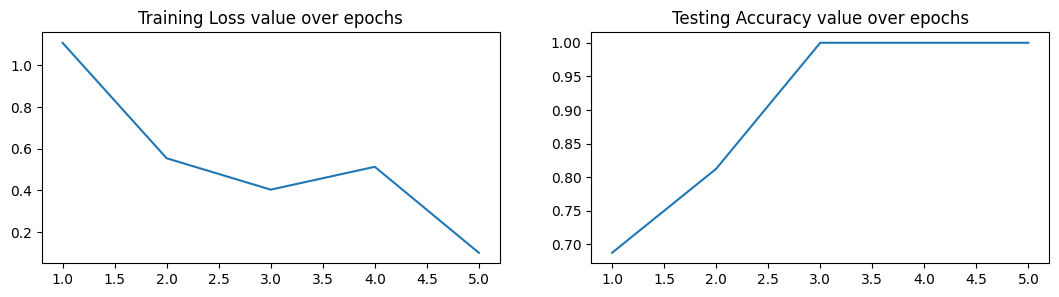

In [ ]:
# Resnet
resnet_models = [resnet18_model, resnet152_model]
resnet_trainloads = [resnet18_train_loader, resnet152_train_loader]
res_test = [resnet18_test_loader, resnet152_test_loader]


for curr_model in resnet_models:

	curr_model = curr_model.to(device)
	for name, layer in model.named_children():
		print(name)

		for param in layer.parameters():
			param.requires_grad = False
		if name == "avgpool":
			layer = nn.AdaptiveAvgPool2d(output_size=(1,1))
		# Accessing the fully connected layer 
		input_features = curr_model.fc.in_features
		if name == 'fc':
			layer = nn.Sequential(nn.Flatten(),
									nn.Linear(input_features, 128),
									nn.ReLU(), # Activation between linear layers
									nn.Dropout(0.2),
									nn.Linear(128, 10)
								).to(device)
		
		
		# print 

		# model.fc = nn.Linear(num_features, 2)
	
		
# print(better_summary(curr_model,(3, 224, 224)))

	optimizer = torch.optim.Adam(curr_model.parameters(), lr=1e-3)
	for x in range(len(resnet_trainloads)):
		train_losses, train_accuracies, train_time = perform_training(curr_model, resnet_trainloads[x])
		n_epochs = 5

		# After training is complete see model accuarcy 
		curr_model.eval() 
		test_accuracies = []

		with torch.no_grad():
			for x, y in res_test[x]:
				x, y = x.to(device), y.to(device)
				acc = accuracy(curr_model, x, y)
				test_accuracies.append(acc)
		test_accuracy = np.mean(test_accuracies)

		
		print(f"Final test accuracy: {test_accuracy:.4f}")
		plt.figure(figsize=(13,3))
		plt.subplot(121)
		plt.title('Training Loss value over epochs')
		plt.plot(np.arange(n_epochs) + 1, train_losses)
		plt.subplot(122)
		plt.title('Testing Accuracy value over epochs')
		plt.plot(np.arange(n_epochs) + 1, train_accuracies)


### Classifying Images
<p>In this section we test our trained models on images from Google Images
from 3 of CIFAR10's classes: airplane, cat, and frog<p>